In [1]:
# import dependencies
from PIL import Image
import cv2
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn import linear_model 
import pytesseract
import os
import shutil

# 1. Image pre-process
To prepare wanted data points, we have to pre-process the image, including:
- read image
- find data points
- delet the first part 
- delete the descending part
- sort the data points


In [49]:
'''
Image pre-process
Image Read -> Find data points -> delete vertical part(last descending part) -> Image Mask
'''

# load image by opencv, transfer bgr to rgb
def load_cv_image(img_path):
    cv_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    np_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    return np_img

# rgb to gray; the relationn between rgb and grey parameters
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

# Extract data points by color
def color_filter(img, color_range):
    #exclude input errors
    assert len(img.shape) == 3
    assert len(color_range) == 6
    h, w, _ = img.shape
    X = []
    y = []

    for i in range(h):
        for j in range(w):
            r = img[i,j,0]
            g = img[i,j,1]
            b = img[i,j,2]
            if color_range[0] <= r <= color_range[1] \
            and color_range[2] <= g <= color_range[3] \
            and color_range[4] <= b <= color_range[5]:
                X.append(j)
                y.append(i)
            else:
                pass
    return X, y

# find 4 corners of frame in the figure
def find_corner(img, find_corner_params):
    color_range = find_corner_params["color_range"]
    X_num = find_corner_params["X_search_range"]
    y_num = find_corner_params["y_search_range"]
    dic_corners = {}
    X, y = color_filter(img, color_range)
    X_count = Counter(X).most_common(X_num)
    y_count = Counter(y).most_common(y_num)
    X_list = []
    y_list = []
    for i in range(X_num):
        X_list.append(X_count[i][0])
    for j in range(y_num):
        y_list.append(y_count[j][0])
        
    x_left = np.min([x for x in X_list if x < np.mean(X_list)])
    x_right = np.max([x for x in X_list if x > np.mean(X_list)])
    y_up = np.min([y for y in y_list if y < np.mean(y_list)])
    y_down = np.max([y for y in y_list if y > np.mean(y_list)])
    dic_corners["left_down"] = (x_left, y_down)
    dic_corners["left_up"] = (x_left, y_up)
    dic_corners["right_down"] = (x_right, y_down)
    dic_corners["right_up"] = (x_right, y_up)
    dic_corners["plt_w"] = x_right - x_left
    dic_corners["plt_h"] = y_down - y_up
    return dic_corners


#r=g=b, keep, otherwise turm into white
def color_erase(img):
    assert len(img.shape) == 3
    img_new = img.copy()
    h, w, _ = img.shape
    for i in range(h):
        for j in range(w):
            r = img[i,j,0]
            g = img[i,j,1]
            b = img[i,j,2]
            if r == g and g == b:
                pass
            else:
                img_new[i,j,:] = np.array([255,255,255], dtype=np.uint8)
    return img_new
                
# sort X and y in order of X, arranging data according to x axis
def sort_X(X, y):
    X_sort = sorted(X)
    y_sort = [y for _,y in sorted(zip(X,y))]
    return X_sort, y_sort

# delete start part
def del_start(X_orig, y_orig, x_thr=300):
    index = X_orig.index(x_thr+1)
    X_new = X_orig.copy()
    y_new = y_orig.copy()
    del X_new[:index]
    del y_new[:index]
    return X_new, y_new

# delete vertical part, delete when more than 50 points share the same x value
def del_vert(X_orig, y_orig, vert_thr=50):
    
    x_temp = []
    y_temp = []
    del_part = []
    x_del = []
    y_del = []
    
    for i in range(len(X_orig)):
        if len(x_temp) == 0:
            x_start = i
            x_temp.append(X_orig[i])
            y_temp.append(y_orig[i])
        else:
            if X_orig[i] != x_temp[0]:
                num_x = i - x_start
                if num_x > vert_thr:
                    del_part.append((x_start, i))
                elif len(y_temp)>0 and np.max(y_temp) -50 > np.min(y_temp):
                    m = y_temp.index(min(y_temp))
                    del_part.append((x_start, x_start + m))
                    del_part.append((x_start + m + 1, i))
                y_temp = []
                x_temp = []
                x_start = i
                x_temp.append(X_orig[i])
                y_temp.append(y_orig[i])
            else:
                y_temp.append(y_orig[i])
                
    X_new = X_orig.copy()
    y_new = y_orig.copy()
    for delete in del_part[::-1]:
        x_del = x_del + X_new[delete[0] : delete[1]]
        y_del = y_del + y_new[delete[0] : delete[1]] 
        del X_new[delete[0] : delete[1]]
        del y_new[delete[0] : delete[1]]  
    return X_new, y_new, x_del, y_del


# mask image in red
def image_mask(img, mask_X, mask_y, color = np.array([255,0,0], dtype=np.uint8)):
    assert len(mask_X) == len(mask_y)
    img_mask = img.copy()
    for i in range(len(mask_X)):
        col = mask_X[i]
        raw = mask_y[i]
        img_mask[raw,col,:] = color
    return img_mask

def draw_line_cv(img, k, b, color=(255,0,0), line_width=1):
    h, w, _ = img.shape
    pt1 = (0, int(b))
    pt2 = (w-1, int(k*(w-1)+b))
    cv2.line(img, pt1, pt2, color, line_width)
    return img

# 2. RANSAC
In order to extract the two lines, we using RANSAC algorithm proposed by scikit_learn  
**data_valid** and **model_valid** are used to limit the extracted line

In [87]:
'''
Find line in image using ransac
'''

class line_ransac:
    def __init__ (self, X, y, ransac_params):
        self.X = X
        self.y = y
        self.max_iter = ransac_params["max_iter"]
        self.mean_iter = ransac_params["mean_iter"]
        self.l1_gap = ransac_params["line1_gap"]
        self.l2_gap = ransac_params["line2_gap"]
        self.l1_cut_range = ransac_params["line1_cut_range"]
        self.l2_cut_range = ransac_params["line2_cut_range"]
        self.l1_k_min = ransac_params["line1_k_min"]
        self.l2_k_max = ransac_params["line2_k_max"]
    def valid_data_line1(self):
        def valid_data(X, y):
            if (np.max(X) - np.min(X)) < self.l1_gap :
                return True
            else:
                return False
        return valid_data

    def valid_data_line2(self):
        def valid_data(X, y):
            if (np.max(X) - np.min(X)) < self.l2_gap :
                return True
            else:
                return False
            return valid_data
        
    def valid_model_line1(self):
        def valid_model(model, X, y):
            k = model.coef_
            if 0> k > self.l1_k_min:
                return True
            else:
                return False
        return valid_model
    
    def valid_model_line2(self):
        def valid_model(model, X, y):
            k = model.coef_
            if k < self.l2_k_max:
                return True
            else:
                return False
        return valid_model
    
    def find_line_ransac(self, cut_range = 0, min_samp = None, res_thr = None, valid_data=None, valid_model=None):
        ransac = linear_model.RANSACRegressor(max_trials=self.max_iter,min_samples=min_samp, residual_threshold=res_thr, \
                                    is_data_valid=valid_data, is_model_valid=valid_model)
        thr = (1-cut_range)*np.median(self.X) + cut_range*np.max(self.X)
        index = (self.X).index(int(thr))
        X = (self.X).copy()
        y = (self.y).copy()
        del X[:index]
        del y[:index]
        X = np.array(X)[:,np.newaxis]
        y = np.array(y)[:,np.newaxis]
        ransac.fit(X,y)
        k = ransac.estimator_.coef_
        b = ransac.estimator_.intercept_
        return k, b
    
    def line_extraction_ransac(self):

        k1_list = []
        b1_list = []
        k2_list = []
        b2_list = []
        for j in range(self.mean_iter):
            k1_temp, b1_temp = self.find_line_ransac(cut_range = self.l1_cut_range, \
                                                     valid_data=self.valid_data_line1(), \
                                                     valid_model=self.valid_model_line1())
            k2_temp, b2_temp = self.find_line_ransac(cut_range = self.l2_cut_range, \
                                                     valid_data=self.valid_data_line2(), \
                                                     valid_model=self.valid_model_line2())
            k1_list.append(k1_temp)
            b1_list.append(b1_temp)
            k2_list.append(k2_temp)
            b2_list.append(b2_temp)
            
        k1 = np.mean(k1_list)
        b1 = np.median(b1_list)
        
        b2 = np.max(b2_list)
#         k2 = np.mean(k2_list)
        k2 = k2_list[b2_list.index(b2)]
        x_cross = - (b1 - b2) / (k1 - k2)
        y_cross = k1 * x_cross + b1
        res = {}
        res["k1"] = k1
        res["b1"] = b1
        res["k2"] = k2
        res["b2"] = b2
        res["x_cross"] = x_cross
        res["y_cross"] = y_cross
        return res
    


# 3. OCR

This section aims at finding the coordinate scale using image segmentaation, image processing and OCR

In [4]:
'''
Fine X/y axis location and their scale
'''

# mark_X: first tick mark in X axis
# mark_y: second tick mark in y aixs (to avoid mixing with data)
# attention: the division of x axis and y axis by 5
def find_mark(img, dic_corners, find_mark_params):
    thr = find_mark_params["thr"]
    search_range= find_mark_params["search_range"]
    bb_size_X= find_mark_params["bb_size_X"]
    jug_cond_X= find_mark_params["jug_cond_X"]
    bb_size_Y= find_mark_params["bb_size_Y"]
    jug_cond_Y= find_mark_params["jug_cond_Y"]
    SHOW_MARK= find_mark_params["SHOW_MARK"]
    pt_orig = dic_corners["left_down"]
    pt_xMax = dic_corners["right_down"]
    pt_yMax = dic_corners["left_up"]
    x_rough = int((pt_xMax[0] - pt_orig[0])/5 + pt_orig[0])
    y_rough = int(pt_orig[1] - 2*(pt_orig[1] - pt_yMax[1])/5)
    dic_markers = {}
    
    for i in range(x_rough-search_range, x_rough+search_range):
        Bounding_box = rgb2gray(img[pt_orig[1]-bb_size_X[0]:pt_orig[1],i-bb_size_X[1]:i,:])
        valid_num = np.sum(Bounding_box < thr)
        if SHOW_MARK:
            print("\n")
            print("X index: " + str(i))
            print(np.squeeze(Bounding_box))
            print("X valid number: {}".format(valid_num))
            plt.imshow(Bounding_box.T, cmap='gray')
            plt.show()
        if valid_num >= jug_cond_X:
            dic_markers["mark_X"] = i
            if SHOW_MARK:
                print("\n")
                print("mark X: {}".format(i))
            break

    for i in range(y_rough-search_range, y_rough+search_range):
        Bounding_box = rgb2gray(img[i:i+bb_size_Y[0],pt_orig[0]+1:pt_orig[0]+1+bb_size_Y[1],:])
        valid_num = np.sum(Bounding_box < thr)
        if SHOW_MARK:
            print("\n")
            print("y index: " + str(i))
            print(np.squeeze(Bounding_box))
            print("y valid number: {}".format(valid_num))
            plt.imshow(Bounding_box, cmap='gray')
            plt.show()
        if valid_num >= jug_cond_X:
            dic_markers["mark_y"] = i
            if SHOW_MARK:
                print("\n")
                print("mark y: {}".format(i))
            break

    return dic_markers


# optical caracteristic recognition, with a given picture, identify the numbers inside;
# grey+ resize+ sharpen + binaryzation gray value >180 ->white, otherwise black
def ocr_detector(img, ocr_params, show_img=False):
    scale_w = ocr_params["scale_w"]
    scale_h = ocr_params["scale_h"]
    kernel = ocr_params["kernel"]
    sharpen_lower = ocr_params["sharpen_lower"]
    sharpen_upper = ocr_params["sharpen_upper"]
    img_gray = rgb2gray(img.copy())
    img_h, img_w = img_gray.shape
    img_resize = cv2.resize(img_gray, (int(scale_w * img_w),int(scale_h * img_h)),interpolation=cv2.INTER_LANCZOS4 )
    img_sharpen = cv2.filter2D(img_resize, -1, kernel=kernel)
    _, img_thr = cv2.threshold(img_sharpen,sharpen_lower,sharpen_upper,cv2.THRESH_BINARY)
    code = pytesseract.image_to_string(img_thr, config='digits')
    if show_img:
        plt.imshow(img_thr, cmap="gray")
        plt.show()
        print("code is : {}".format(code))
    return code

# found a area around the given point to identify the real axe value
def image_seg(img, pos_x=0, pos_y=0, bias_w = 0, bias_h = 0, img_w=40,img_h=14):
    assert len(img.shape) ==3
    h, w, _ = img.shape
    h_min = max(pos_y+bias_h, 0)
    h_max = min(pos_y+bias_h+img_h, h)
    w_min = max(pos_x+bias_w, 0)
    w_max = min(pos_x+bias_w+img_w, w)
    im = img[h_min:h_max, w_min:w_max,:].copy()
    return im
    
# find the coordiates in the image frame of all axes values
def find_coordinate(img, dic_corners, dic_markers, find_coor_params):
    pt_orig = dic_corners["left_down"]
    mark_x = dic_markers["mark_X"]
    mark_y = dic_markers["mark_y"]
    bias_w_x = find_coor_params["bias_w_x"]
    bias_h_x = find_coor_params["bias_h_x"]
    img_w_x = find_coor_params["img_w_x"]
    img_h_x = find_coor_params["img_h_x"]
    bias_w_y = find_coor_params["bias_w_y"]
    bias_h_y = find_coor_params["bias_h_y"]
    img_w_y = find_coor_params["img_w_y"]
    img_h_y = find_coor_params["img_h_y"]
    ocr_params = find_coor_params["ocr_params"]
    SHOW_COOR = find_coor_params["SHOW_COOR"]
    dist_x = mark_x - pt_orig[0]
    dist_y = (pt_orig[1] - mark_y) / 2
    # find x coordinate
    coor_x = []
    pos_y = int(pt_orig[1])
    for i in range(6):
        pos_x = int(pt_orig[0] + i * dist_x)
        img_seg = image_seg(img, pos_x, pos_y, bias_w=bias_w_x, bias_h=bias_h_x, img_w=img_w_x, img_h=img_h_x)
        if SHOW_COOR:
            print("\n")
            print("X axis, coordinate: {}".format(i))
            plt.imshow(img_seg, cmap="gray")
            plt.show()
        code = ocr_detector(img_seg,ocr_params,SHOW_COOR)
        if i == 0 and code == "":
            code = str(0)
        if SHOW_COOR:
            print("OCR result is {}".format(code))
        coor_x.append(code)
    # find y coordinate
    coor_y = []
    pos_x = int(pt_orig[0])
    for i in range(6):
        pos_y = int(pt_orig[1] - i * dist_y)
        img_seg = image_seg(img, pos_x, pos_y, bias_w=bias_w_y, bias_h=bias_h_y, img_w=img_w_y, img_h=img_h_y)
        if SHOW_COOR:
            print("\n")
            print("X axis, coordinate: {}".format(i))
            plt.imshow(img_seg, cmap="gray")
            plt.show()
        code = ocr_detector(img_seg,ocr_params,SHOW_COOR)
        if i == 0 and float(code) > 0:
            code = "-" + code
        if SHOW_COOR:
            print("OCR result is {}".format(code))
        coor_y.append(code)
    dic_scale = {}
    dic_scale["CoorX"] = coor_x
    dic_scale["CoorY"] = coor_y
    return dic_scale

# by identify the max number in the fig
def find_peak(img,dic_corners, find_peak_params, ):
    scale_w = find_peak_params["scale_w"]
    scale_h = find_peak_params["scale_h"]
    bias_w_l = find_peak_params["bias_w_l"]
    bias_w_r = find_peak_params["bias_w_r"]
    bias_h = find_peak_params["bias_h"]
    img_w = find_peak_params["img_w"]
    img_h = find_peak_params["img_h"]
    x_thr = find_peak_params["x_thr"]
    y_thr = find_peak_params["y_thr"]
    color_range = find_peak_params["color_range"]
    orc_params = find_peak_params["ocr_params"]
    SHOW_PEAK = find_peak_params["SHOW_PEAK"]
    
    pt_ru = dic_corners["right_up"]
    pt_lu = dic_corners["left_up"]
    img_seg = img[pt_ru[1]+bias_h:pt_ru[1]+bias_h+img_h,\
                  pt_lu[0]+bias_w_l:pt_ru[0]+bias_w_r,:].copy()
#     plt.figure(figsize=(30,3))
#     plt.imshow(img_seg)
#     plt.show()
    X, y = color_filter(img_seg, color_range)
    count_x = Counter(X).most_common(16)
    count_y = Counter(y).most_common(8)
    x_list = []
    y_list = []
    for i in range(16):
        if count_x[i][1] > x_thr:
            x_list.append(count_x[i][0])
    for i in range(8):     
        if count_y[i][1] > y_thr:
            y_list.append(count_y[i][0])
    x_bound_l = np.max([x for x in x_list if x < np.max(x_list) - img_w/2])
    x_bound_r = np.max([x for x in x_list if x > np.max(x_list) - img_w/2])
    y_bound_t = np.min([y for y in y_list if y < np.mean(y_list)])
    y_bound_b = np.max([y for y in y_list if y > np.mean(y_list)])
    img_bb = img_seg[y_bound_t+2:y_bound_b-1,x_bound_l+2:x_bound_r-1,:]
    img_bb = cv2.copyMakeBorder(img_bb, 2,2,2,2,cv2.BORDER_CONSTANT, value=[255,255,255])
    if SHOW_PEAK:
        plt.figure(figsize=(10,3))
        plt.imshow(img_bb)
        plt.show()
    code = ocr_detector(img_bb, orc_params, show_img=SHOW_PEAK)
    return code

# find the ratio of pixel and its values in real pictures
def find_scale(dic_line_params, dic_corners, dic_markers, dic_coor):
    dic_scale = {}
    pt_orig = dic_corners["left_down"]
    mark_x = dic_markers["mark_X"]
    mark_y = dic_markers["mark_y"]
    dist_x = mark_x - pt_orig[0]
    dist_y = (pt_orig[1] - mark_y) / 2
    x_value = []
    y_value = []
    x_coor = dic_coor["CoorX"]
    y_coor = dic_coor["CoorY"]
    for i in range(len(x_coor)-1):
        x_value.append(float(x_coor[i+1]) - float(x_coor[i]))
    for i in range(len(y_coor)-1):
        y_value.append(round(float(y_coor[i+1]) - float(y_coor[i]), 2))
    x_scale = Counter(x_value).most_common(1)[0][0] / dist_x
    y_scale = Counter(y_value).most_common(1)[0][0] / dist_y
    dic_scale["scale_x"] = x_scale
    dic_scale["scale_y"] = y_scale
    return dic_scale

# 4. Integration

Integrate all previous algorithms and give the final results


In [59]:

def model_run (file, data_color_range = [60, 160, 160, 210, 130, 200], start_thr = 200, vert_thr = 80, \
               ransac_params = {}, \
               find_corner_params = {}, find_mark_params = {}, find_coor_params = {}, find_peak_params = {},\
               SHOW_MASK = False, SHOW_RANSAC_LINE = False, SHOW_BORDLINE = False, PRINT_RESULT = False, CHECK_RESULT = False):
    
    img = load_cv_image(file)
    
    # find 4 plot corners to locate the scale information
    dic_corners = find_corner(img, find_corner_params)
    if SHOW_BORDLINE:
        img_bord = img.copy()
        cv2.line(img_bord, dic_corners["left_up"], dic_corners["left_down"], (255,0,0), 2)
        cv2.line(img_bord, dic_corners["left_up"], dic_corners["right_up"], (255,0,0), 2)
        cv2.line(img_bord, dic_corners["left_down"], dic_corners["right_down"], (255,0,0), 2)
        cv2.line(img_bord, dic_corners["right_up"], dic_corners["right_down"], (255,0,0), 2)
        plt.figure(figsize=(20,6))
        plt.title("Bord Image")
        plt.imshow(img_bord)
        plt.show()
    
    # extracted needed data
    X, y = color_filter(img, data_color_range)
    # sort data in the index of X
    X_sortX, y_sortX = sort_X(X, y)
    X_new, y_new = del_start(X_sortX, y_sortX, int(start_thr*dic_corners["plt_w"]+dic_corners["left_down"][0]))
    X_new, y_new, x_del, y_del = del_vert(X_new, y_new, vert_thr)
    if SHOW_MASK:
        img_mask = image_mask(img, X_new, y_new, color=np.array([255,0,0], dtype=np.uint8))
        plt.figure(figsize=(20,6))
        plt.title("Mask Image")
        plt.imshow(img_mask)
        plt.show()
        
    try:
        # RANSAC line extraction
        model_ransac = line_ransac(X_new, y_new, ransac_params)
        dic_line_params = model_ransac.line_extraction_ransac()
        
        k1 = dic_line_params["k1"]
        b1 = dic_line_params["b1"]
        k2 = dic_line_params["k2"]
        b2 = dic_line_params["b2"]
        x_cross = dic_line_params["x_cross"]
        y_cross = dic_line_params["y_cross"]
        if SHOW_RANSAC_LINE:
            img_ransac = img.copy()
            img_ransac = draw_line_cv(img_ransac, k1, b1, line_width=1)
            img_ransac = draw_line_cv(img_ransac, k2, b2, line_width=1)
            cv2.line(img_ransac, (int(x_cross), 0), (int(x_cross), img_ransac.shape[0]), (0,0,0), 1)
            cv2.line(img_ransac, (0, int(y_cross)), (img_ransac.shape[1], int(y_cross)), (0,0,0), 1)
            plt.figure(figsize=(20,6))
            plt.title("RANSAC Image")
            plt.imshow(img_ransac)
            plt.show()
        
        # find coordinate markers
        dic_markers = find_mark(img, dic_corners, find_mark_params)
        # find coordinate
        dic_coor = find_coordinate(img, dic_corners, dic_markers, find_coor_params)
        if CHECK_RESULT:
            while True:
                print ("\nX coordinate is : {}".format(dic_coor["CoorX"]))
                print("If the X coordinate is right, press Enter to the next step")
                print("If there is wrong value, please enter its index and true value")
                data_in = input("Index, Value: ")
                if data_in == "":
                    break
                else:
                    data_in = data_in.split()
                    if len(data_in) != 2:
                        print ("Wrong input type, please write again")
                    else:
                        dic_coor["CoorX"][int(data_in[0])] = data_in[1]
            while True:
                print ("\nY coordinate is : {}".format(dic_coor["CoorY"]))
                print("If the Y coordinate is right, press Enter to the next step")
                print("If there is wrong value, please enter its index and true value")
                data_in = input("Index, Value: ")
                if data_in == "":
                    break
                else:
                    data_in = data_in.split()
                    if len(data_in) != 2:
                        print ("Wrong input type, please write again")
                    else:
                        dic_coor["CoorY"][int(data_in[0])] = data_in[1]
        # find scale
        dic_scale = find_scale(dic_line_params, dic_corners, dic_markers, dic_coor)
        # find peak value
        peak_value = find_peak(img, dic_corners, find_peak_params)
        
        if CHECK_RESULT:
            while True:
                print ("\nPeak value is : {}".format(peak_value))
                print("If the peak value is right, press Enter to the next step")
                print("If it is wrong value, please enter its right value")
                data_in = input("Peak value: ")
                if data_in == "":
                    break
                else:
                    peak_value = data_in
        
        pt_orig = dic_corners["left_down"]
        mark_x = dic_markers["mark_X"]
        mark_y = dic_markers["mark_y"]
        dist_x = mark_x - pt_orig[0]
        dist_y = (pt_orig[1] - mark_y) / 2
        scale_x = dic_scale["scale_x"]
        scale_y = dic_scale["scale_y"]
        pt1_x = (x_cross - pt_orig[0]) * scale_x
        pt1_y = (pt_orig[1] - y_cross) * scale_y
        pt2_y = float(peak_value)
        y_pix = int(pt_orig[1] - (pt2_y - float(dic_coor["CoorY"][0])) / scale_y)
        pt2_x = ((y_pix - b2)/k2 - pt_orig[0]) * scale_x
        pt1 = (pt1_x, pt1_y)
        pt2= (pt2_x, pt2_y)
        
        if PRINT_RESULT:
            print("=============Resualt=============")
            print("\n")
            print("The origin of coordinate is: {}".format(pt_orig))
            print("The firs marker in X axis is: {}".format((mark_x, pt_orig[1])))
            print("The second marker in y axis is: {}".format((pt_orig[0], mark_y)))
            print("The distance of every tick mark in X axis is {} pixel".format(dist_x))
            print("The distance of every tick mark in y axis is {} pixel".format(dist_y))
            print("The scale in x axis is: {}".format(dic_coor["CoorX"]))
            print("The scale in y axis is: {}".format(dic_coor["CoorY"]))
            print("The x scale is {}/pixel".format(float('%0.3f'%scale_x)))
            print("The y scale is {}/pixel".format(float('%0.5f'%scale_y)))
            print("Line 1 is: y = {}x + {}".format(('%0.3f'%k1), ('%0.3f'%b1)))
            print("Line 2 is: y = {}x + {}".format(('%0.3f'%k2), ('%0.3f'%b2)))
            print("The first point is: ({}, {})".format(float('%0.3f'%pt1_x), float('%0.3f'%pt1_y)))
            print("The second point is: ({}, {})".format(float('%0.3f'%pt2_x), float('%0.3f'%pt2_y)))
            print("\n")
            print("=============Finish=============")
        return pt1, pt2
                   
    except ValueError:
        file_path, file_name = os.path.split(file)
        print( "{} has problem in automatic data processing, please check manually".format(file_name))   
        pt1 = ()
        pt2 = ()
        return pt1, pt2

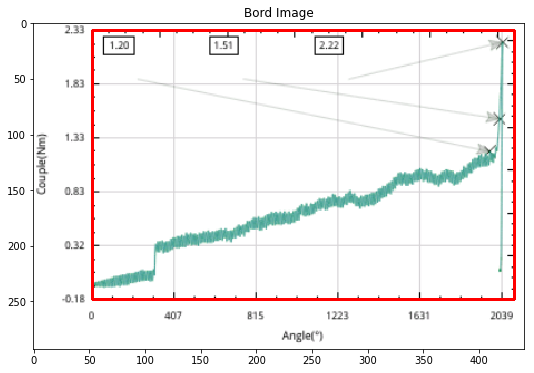

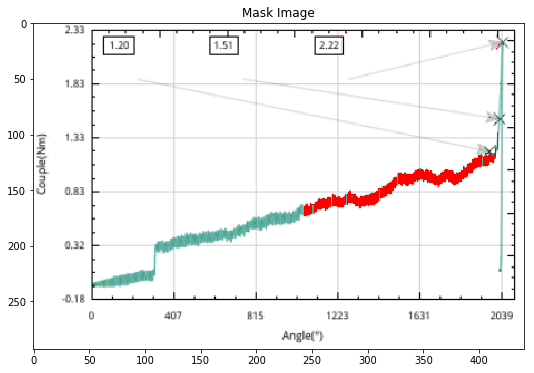

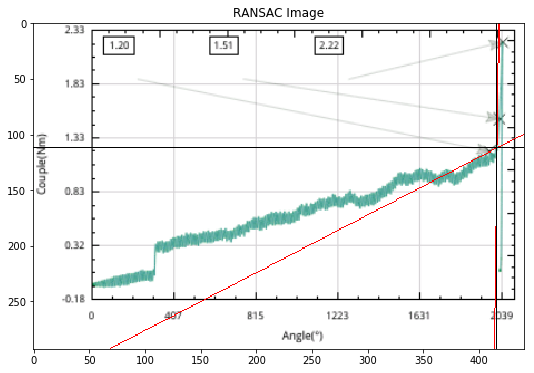


X coordinate is : ['0', '407', '815', '', '1634', '2039']
If the X coordinate is right, press Enter to the next step
If there is wrong value, please enter its index and true value
Index, Value: 3 1223

X coordinate is : ['0', '407', '815', '1223', '1634', '2039']
If the X coordinate is right, press Enter to the next step
If there is wrong value, please enter its index and true value
Index, Value: 

Y coordinate is : ['-0.18', '0.32', '0.83', '1.33', '1.83', '']
If the Y coordinate is right, press Enter to the next step
If there is wrong value, please enter its index and true value
Index, Value: 5 2.33

Y coordinate is : ['-0.18', '0.32', '0.83', '1.33', '1.83', '2.33']
If the Y coordinate is right, press Enter to the next step
If there is wrong value, please enter its index and true value
Index, Value: 

Peak value is : 
If the peak value is right, press Enter to the next step
If it is wrong value, please enter its right value
Peak value: 2.22

Peak value is : 2.22
If the peak value i

In [89]:
# configuration
data_color_range = [60, 160, 160, 210, 130, 200]
start_thr = 0.5
vert_thr = 80

SHOW_MASK = True
SHOW_RANSAC_LINE = True
SHOW_BORDLINE = True
PRINT_RESULT = True
CHECK_RESULT = True


ransac_params = {"max_iter": 10000, "mean_iter":10, \
                "line1_gap":50, "line1_cut_range":0.6, "line1_k_min":-1, \
                "line2_gap":5, "line2_cut_range":0.95, "line2_k_max":-10}

find_corner_params = {"color_range":[0, 100, 0, 100, 0, 100], "X_search_range":4, "y_search_range":4}

ocr_params = {"scale_w":2, "scale_h":2, "sharpen_lower":160, "sharpen_upper":255, \
               "kernel": np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]], np.float32) }

find_mark_params = {"SHOW_MARK":False, "thr": 170, "search_range":10, \
                    "bb_size_X":(12,1), "jug_cond_X":5, \
                    "bb_size_Y":(1,12), "jug_cond_Y":5}

find_coor_params = {"SHOW_COOR":False, "bias_w_x":-20, "bias_h_x":8, "img_w_x":30, "img_h_x":14, \
                    "bias_w_y":-32, "bias_h_y":-7, "img_w_y":30, "img_h_y":14, "ocr_params":ocr_params}

find_peak_params = {"SHOW_PEAK":False, "scale_w":2, "scale_h":2, \
                    "bias_w_l":5, "bias_w_r":-50, "bias_h":2, "img_w":40, "img_h":20, \
                    "x_thr":12, "y_thr":50, "color_range":[0,180,0,180,0,180],\
                    "ocr_params":ocr_params}
# file = "E:\Faurecia\Data\SB_T65_non_visible\SB_T65_NV&Plate_T65\SB_T65_NV&Plate_T65_Ep2_7\SB_T65_NV&Plate_T65_Ep2_7_T1_7\SB_T65_NV&Plate_T65_Ep2_7_T1_7_001.PNG"
#file = "SB_T65_non_visible/SB_T65_NV&Plate_LGF20/SB_T65_NV&Plate_LGF20_Ep2/SB_T65_NV&Plate_LGF20_Ep2_T2_2/SB_T65_NV&Plate_LGF20_Ep2_T2_2_002.PNG"
file = "Data/SB_T65_non_visible/SB_T65_NV&Plate_MD20/SB_T65_NV&Plate_MD20_Ep2_7/SB_T65_NV&Plate_MD20_Ep2_7_T2_2/SB_T65_NV&Plate_MD20_Ep2_7_T2_2_001.PNG"
pt1, pt2 = model_run (file, data_color_range, start_thr, vert_thr, ransac_params,\
                      find_corner_params, find_mark_params, find_coor_params,find_peak_params,\
                      SHOW_MASK, SHOW_RANSAC_LINE, SHOW_BORDLINE, PRINT_RESULT, CHECK_RESULT)

# Experiment

In [ ]:
# Load data
localpath = "E:\Faurecia\Data"
dict_del = {}
dict_crossp_x = {}
dict_crossp_y = {}
for subdir, dirs, files in os.walk(localpath):
    for file in files:
        if "Archive" in subdir:
            try:
                shutil.rmtree(subdir)
            except FileNotFoundError:
                pass
        elif "treatment" in subdir:
            pass
        else:
            if ".PNG" in file:
                filename = file
                imagepath = os.path.join(subdir, file)
#                 print (imagepath)
                print (filename)
                img = load_cv_image(imagepath)

        # image mask
                color_range = [60, 160, 160, 210, 130, 200]
                num_thr = 80
                x_thr = 300
                X, y = color_filter(img, color_range)
                X_sortX, y_sortX = sort_X(X, y)

                X_new, y_new = del_start(X_sortX, y_sortX, x_thr)
                X_new, y_new, x_del, y_del = del_vert_1(X_new, y_new,filename, dict_del, num_thr)
                img_mask = image_mask(img, X_new, y_new, color=np.array([255,0,0], dtype=np.uint8))
#                 img_mask_2 = image_mask(img_mask, x_del, y_del, color=np.array([255,0,255], dtype=np.uint8))
#                 X_new, y_new = del_vert(X_sortX, y_sortX,filename, dict_del, num_thr)
#                 X_new, y_new = del_start(X_new, y_new, x_thr)
#                 img_mask = image_mask(img, X_new, y_new, color=np.array([255,0,0], dtype=np.uint8))

                plt.imsave(localpath + "\After_treatment\ "+ filename[:-4]+"1.PNG", img_mask)
                
                max_iter = 100000
                try:
                    dic_line_params = line_extraction_ransac(X_new, y_new, max_iter)
                    k1 = dic_line_params["k1"]
                    b1 = dic_line_params["b1"]
                    k2 = dic_line_params["k2"]
                    b2 = dic_line_params["b2"]
                    x_cross = dic_line_params["x_cross"]
                    y_cross = dic_line_params["y_cross"]
                    img_ransac = img.copy()
                    img_ransac = draw_line_cv(img_ransac, k1, b1,line_width=1)
                    img_ransac = draw_line_cv(img_ransac, k2, b2,line_width=1)

                    dict_crossp_x[filename] = x_cross
                    dict_crossp_y[filename] = y_cross
    #                 print("Cross point is: ({}, {})".format(float('%0.3f'%x_cross), float('%0.3f'%y_cross)))

                    # draw horizontal and vertical line to cross the axes
                    cv2.line(img_ransac, (int(x_cross), 0), (int(x_cross), img_ransac.shape[0]), (0,0,0), 1)
                    cv2.line(img_ransac, (0, int(y_cross)), (img_ransac.shape[1], int(y_cross)), (0,0,0), 1)
                    plt.imsave(localpath + "\After_treatment\ "+ filename[:-4]+"2.PNG",img_ransac)
                except ValueError:
                    pass

In [ ]:
max_iter = 100000
dic_line_params = line_extraction_ransac(X_new, y_new, max_iter)
k1 = dic_line_params["k1"]
b1 = dic_line_params["b1"]
k2 = dic_line_params["k2"]
b2 = dic_line_params["b2"]
x_cross = dic_line_params["x_cross"]
y_cross = dic_line_params["y_cross"]
img_ransac = img.copy()
img_ransac = draw_line_cv(img_ransac, k1, b1,line_width=1)
img_ransac = draw_line_cv(img_ransac, k2, b2,line_width=1)

print("Cross point is: ({}, {})".format(float('%0.3f'%x_cross), float('%0.3f'%y_cross)))

# draw horizontal and vertical line to cross the axes
cv2.line(img_ransac, (int(x_cross), 0), (int(x_cross), img_ransac.shape[0]), (0,0,0), 2)
cv2.line(img_ransac, (0, int(y_cross)), (img_ransac.shape[1], int(y_cross)), (0,0,0), 2)
plt.imshow(img_ransac)

In [ ]:
dic_scale = find_scale(dic_line_params, dic_corners, dic_markers, dic_coor)

In [ ]:
dic_corners = find_corner(img)
dic_markers = find_mark(img,dic_corners)

pt_orig = dic_corners["left_down"]
mark_x = dic_markers["mark_X"]
mark_y = dic_markers["mark_y"]
dist_x = mark_x - pt_orig[0]
dist_y = (pt_orig[1] - mark_y) / 2

print("The origin of coordinate is: {}".format(pt_orig))
print("The firs marker in X axis is: {}".format((mark_x, pt_orig[1])))
print("The second marker in y axis is: {}".format((pt_orig[0], mark_y)))
print("The distance of every tick mark in X axis is {} pixel".format(dist_x))
print("The distance of every tick mark in y axis is {} pixel".format(dist_y))

dic_coor = find_coordinate(img, dic_corners, dic_markers)
print("The scale in x axis is: {}".format(dic_coor["CoorX"]))
print("The scale in y axis is: {}".format(dic_coor["CoorY"]))

dic_scale = find_scale(dic_line_params, dic_corners, dic_markers, dic_coor)
scale_x = dic_scale["scale_x"]
scale_y = dic_scale["scale_y"]
print("The x scale is {}/pixel".format(float('%0.3f'%scale_x)))
print("The y scale is {}/pixel".format(float('%0.5f'%scale_y)))


pt1_x = (x_cross - pt_orig[0]) * scale_x
pt1_y = (pt_orig[1] - y_cross) * scale_y
pt2_y = float(find_peak(img, dic_corners))
y_pix = int(pt_orig[1] - (pt2_y - float(dic_coor["CoorY"][0])) / scale_y)
pt2_x = ((y_pix - b2)/k2 - pt_orig[0]) * scale_x
print("The first point is: ({}, {})".format(float('%0.3f'%pt1_x), float('%0.3f'%pt1_y)))
print("The second point is: ({}, {})".format(float('%0.3f'%pt2_x), float('%0.3f'%pt2_y)))